# Exercise 6: Logistic regression and classification

You will be pleased to find that the framework for logistic regression is very similar to that of the linear regression. For this exercise we use the `GLM` method in the statsmodels library (https://www.statsmodels.org/stable/glm.html), in which we specify the model via the model matrix `X`. There is also an equivalent method, `glm`, that allows specification via the formula API just as for linear regression. The sklearn library has also a `LogisticRegression` method, but note that it by default regularizes the estimated coefficients using an L2-penalty. To run a classical logistic regression with parameters estimated by maximum likelihood, you will need to set `penalty = 'none'`.

In [2]:
# Import relevant packages
import numpy as np
from pandas import read_csv, DataFrame
from math import log, sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from typing import Tuple

## Getting familiar with the model

### Translation between log-odds and probabilities


Implement the standard logistic function `sigma` as well as its inverse, the logit function. Make a plot of `sigma`

Explain how these two functions are used to transform a probability into log-odds and vice versa.

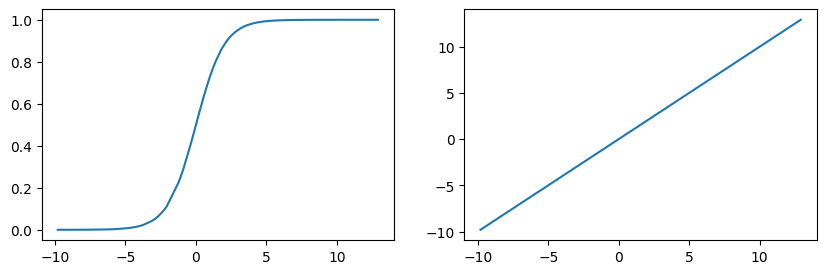

In [3]:
def sigma(eta: float) -> float:
    """
    Takes the value of a linear regression, eta, and turns it into a probability
    """
    eeta = np.e**(-eta)
    return 1 / ( 1 + eeta )
def logit(prob: float) -> float:
    """
    Takes the probability of a logistic regressian, prob, and turnt it into a linea regression value, eta
    """
    return np.log(prob / ( 1 - prob ))
def linear_regression(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Predicts \hat{y} from a vector of observations and a vector of coefficients.
    """
    if X.shape[1] != beta.shape[0]:
        X = np.c_[np.ones(X.shape[0]), X]
    return X.dot(beta)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
X = np.random.randint(-5, 5, (100, 10))
beta = (np.random.rand(11) - 0.5) * 2

lin_X = np.sort(linear_regression(X, beta))
y_1 = sigma(lin_X)
y_2 = logit(y_1)
ax[0].plot(lin_X, y_1)
ax[1].plot(lin_X, y_2)
plt.show()
# Just as expected, the sigma is an S curve and the logit is linear.
# The sigma function fraps a linear regression to turn it into a logistic regression, clamping it between 0 and 1.
# The logit does the opposite, it takes the logistic regression curve and turns it into a linear regression.

Consider a logistic regression model with a single feature $X$ where $\beta_0=0.3$ and $\beta_1=0.7$. 

A) What is the probability of Y=1 when X=5?

B) What are the odds of Y=1 for X=5?

C) What is the *odds ratio* comparing odds of Y=1 when X=8 to the odds when X=5?

In [4]:
# A
beta = np.array([0.3, 0.7])
X5 = np.array([[5]])
lin_y = linear_regression(X5, beta)
prob = sigma(lin_y)
print(f"Probability of Y=1 when X=5 is {prob[0]*100:.1f}%")

# B
def get_odds(prob: float) -> float:
    return prob / ( 1 - prob )

odds = get_odds(prob)
print(f"The odds of Y=1 are {odds[0]:.1f} to one")

# C
X8 = np.array([[8]])
def logistic_regression(X, beta):
    """
    Computes the logistic regression probability with a data matrix X and a vector of coefficients beta
    """
    return sigma(linear_regression(X, beta))
prob = logistic_regression(X8, beta)
odds8 = get_odds(prob)
odds_ratio = odds8 / odds
print(f"The odds ratio says that Y being 1 when X is 8 is {odds_ratio[0]:.1f} times more likely than Y being 1 when X is 5")

Probability of Y=1 when X=5 is 97.8%
The odds of Y=1 are 44.7 to one
The odds ratio says that Y being 1 when X is 8 is 8.2 times more likely than Y being 1 when X is 5


## Load data

Load the `Default` data set from the ISLwR book, which is a simulated data set containing information on ten thousand customers. We will recreate the results in section 4.3. The aim with the data is to predict which customers will default on their credit card debt.

`default`: A binary variable with levels No and Yes indicating whether the customer defaulted on their debt.

`student` A factor with levels No and Yes indicating whether the customer is a student

`balance` The average balance that the customer has remaining on their credit card after making their monthly payment

`income` Income of customer

In [4]:
df = read_csv('Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


Split data into a training set and a test set

In [5]:
test_fraction = 5 # 1 / value
seed = 1337

def set_seed(seed: int):
    np.random.seed(int)

def split_data(df: DataFrame, test_fraction: int) -> Tuple[DataFrame, DataFrame]:
    """Splits the dataframe into train and test sets according to test_fraction"""
    n = len(df)
    test_size = n // test_fraction
    test_sample = np.random.choice(n, test_size, replace=False)
    test_data = df.loc[test_sample]
    train_data = df.drop(test_sample)
    return train_data, test_data

train_df, test_df = split_data(df, test_fraction)
print(len(df), len(train_df), len(test_df))

10000 8000 2000


## Fitting the logistic regression

A logistic regression model is specified as

`sm.GLM(y, X, family=sm.families.Binomial(link = sm.families.links.logit()))`

Here we have specified
1. the outcome variable Y
2. the model matrix X, which specifies how features enter the model
3. the *family* of distributions for Y, which is the *binomial distribution*
4. the *link function*, which is the *logit* for performing logistic regression. This link function is the default for the binomial, so we can leave it out.

As for linear regression, the model is fitted with the `fit` method. From the resulting object you can obtain parameters and the fitted values on the training data. You predict with `predict` method and you can see the output via `summary` method.

Fit a logistic regression model, `M1`, that has `balance` as the only feature, and check your results against Table 4.1 in ISLwR.

In [6]:
y_train = np.where(train_df['default'] == 'No', 0, 1)
X_train = train_df['balance']
X_train_constant = sm.add_constant(X_train)
M1 = sm.GLM(y_train, X_train_constant, family=sm.families.Binomial()).fit()
""" Book data:
|           | Coefficient | Std. error | z-statistic | p-value |
| Intercept |    −10.6513 |     0.3612 |       −29.5 | <0.0001 |
| balance   |      0.0055 |     0.0002 |        24.9 | <0.0001 |
"""
M1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -626.92
Date:                Thu, 14 Sep 2023   Deviance:                       1253.8
Time:                        11:41:03   Pearson chi2:                 4.50e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1218
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8120      0.416    -26.006      0.000     -11.627      -9.997
balance        0.0056      0.000     22.056      0.000       0.005       0.006
==============================================================================
"""

Fit the exact same model, but using `LogisticRegression` from sklearn, taking care that you turn off regularization.

In [7]:
from sklearn.linear_model import LogisticRegression as SKLLogisticRegression
X_train_reshaped = np.reshape(X_train, (-1, 1))
M1sk = SKLLogisticRegression(penalty=None, random_state=seed).fit(X_train_reshaped, y_train)
coff = M1sk.coef_
intercept = M1sk.intercept_
# stderror = I am not calculating this manually fuck you. See https://stackoverflow.com/a/58357360/9877700 for how to do this
# and https://stackoverflow.com/q/27928275/9877700 for p values
print(f"Intercept: {intercept}")
print(f"Coefficients: {coff}")
# Same valuer, I'm happy.

Intercept: [-10.81199243]
Coefficients: [[0.00557246]]


Fit another model, `M2`, that takes a single *categorical* feature, `student`, and check the results against Table 4.2

In [8]:
X_train = train_df['student']
# We need to use one-hot encoding to create a dummy variable. 1 = student,
X_train = np.where(X_train == "No", 0, 1)
X_train_constant = sm.add_constant(X_train)
M2 = sm.GLM(y_train, X_train_constant, family=sm.families.Binomial()).fit()
""" Book data:
|              | Coefficient | Std. error | z-statistic | p-value |
| Intercept    |     −3.5041 |     0.0707 |      −49.55 | <0.0001 |
| student[Yes] |      0.4049 |     0.1150 |        3.52 |  0.0004 |
"""
M2.summary()
# Pretty close. M1 was closer though. Randomness innit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1142.3
Date:                Thu, 14 Sep 2023   Deviance:                       2284.6
Time:                        11:41:03   Pearson chi2:                 8.00e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001085
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5247      0.080    -44.079      0.000      -3.681      -3.368
x1             0.3901      0.130      2.998      0.003       0.135       0.645
==============================================================================
"""

Fit a model, `M3`, that has an interaction between `student` and `balance`.

In [9]:
# If you don't copy it gives you a "view", and then the line below will overwrite the original df
X_train = train_df[['balance', 'student']].copy()
X_train['student'] = np.where(X_train['student'] == "No", 0, 1)
X_train['balanceXstudent'] = X_train['balance'] * X_train['student'] # Interaction
X_train_constant = sm.add_constant(X_train)
M3 = sm.GLM(y_train, X_train_constant, family=sm.families.Binomial()).fit()
M3.summary()
# One at a time:
#   Intercept: Affect when balance = 0 and you're no a student.
#   Balance: Effect of balance on non-students
#   Student: Effect of students
#   BalanceXStudent: Additional effect of balance for students.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -615.68
Date:                Thu, 14 Sep 2023   Deviance:                       1231.4
Time:                        11:41:03   Pearson chi2:                 4.65e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1243
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -11.2468      0.547    -20.564      0.000     -12.319     -10.175
balance             0.0060      0.000     17.547      0.000       0.005       0.007
student             0.1297      0.912      0.142      0.887      -1.659       1.918
balanceXstudent    -0.0005      0.001     -0.980      0.327      -0.002       0.001
===================================================================================
"""

For each of the three models, write down the formula for the estimated probabilities using the estimated coefficients. Write down also the formula for the estimated log odds.

*Solution*  
M1:  
$$
p(X)=\frac{1}{1 + \mathrm{e}^{-(-10.6513+X_1\cdot0.0055)}}
$$
$$
\begin{bmatrix}
-10.6513 \\ 0.055
\end{bmatrix} 
\cdot
\begin{bmatrix}
1      & x_{1}\\
\vdots & \vdots \\
1      & x_{n}
\end{bmatrix} = 
\log \frac{1}{1 - p(X)}-1 =
\log \frac{1}{1 - \frac{1}{1 + \mathrm{e}^{-(-10.6513+X_1\cdot0.0055)}}}-1 =
$$
M2:  
$$
p(X)=\frac{1}{1 + \mathrm{e}^{-(-3.5393+X_1\cdot0.3393)}}
$$
$$
\begin{bmatrix}
-3.5393 \\ 0.3393
\end{bmatrix} 
\cdot
\begin{bmatrix}
1      & x_{1}\\
\vdots & \vdots \\
1      & x_{n}
\end{bmatrix} = 
\log \frac{1}{1 - \frac{1}{1 + \mathrm{e}^{-(-3.5393+X_1\cdot0.3393)}}}-1 =
$$
M3:  
$$
p(X)=\frac{1}{1 + \mathrm{e}^{-(-10.3375 + X_1\cdot0.055 + X_2\cdot(-0.7702) + X_3\cdot(-2.964-10^6))}}
$$
$$
\begin{bmatrix}
-10.3375 \\ 0.0055 \\ -0.7702 \\ -2.964-10^6
\end{bmatrix} 
\cdot
\begin{bmatrix}
1      & x_{1,1} & x_{1,2} & x_{1,1}\cdot x_{1,2} \\
\vdots & \vdots  & \vdots  & \vdots               \\
1      & x_{n,1} & x_{n,2} & x_{n,1}\cdot x_{n,2} \\
\end{bmatrix} = 
\log \frac{1}{1 - \frac{1}{1 + \mathrm{e}^{-(-10.3375 + X_1\cdot0.055 + X_2\cdot(-0.7702) + X_3\cdot(-2.964-10^6))}}}-1 =
$$


## Prediction 

Fitted values --the mean response-- are obtained as for the linear regression. However a main difference is that the mean is not used directly as a prediction of Y. Rather, we choose a threshold $\alpha$ and predict $Y=1$ whenever $P(Y=1|X) > \alpha$. Usually we take $\alpha = 0.5$, unless we specifically wish to incur a "higher cost" for some kinds of misclassifications.

Using $\alpha = 0.5$, compute the training error rate (proportion of wrong classifications) for models M1, M2, and M3.

In [10]:
# Yeah I could have made a function but I was in too deep okay

alpha = 0.5
X_train = train_df['balance']
X_train_constant = sm.add_constant(X_train)
y_train = np.where(train_df['default'] == "No", 0, 1)
M1_probs = np.array(M1.predict(X_train_constant))
M1_preds = np.where(M1_probs > alpha, 1, 0)
def error(preds, y_train):
    return sum([1 for i in range(len(y_train)) if y_train[i] != preds[i]]) / len(y_train)
M1_error = error(M1_preds, y_train)
print(f"Error rate of M1: {M1_error}")

X_train = train_df['student']
X_train = np.where(X_train == "No", 0, 1)
X_train_constant = sm.add_constant(X_train)
M2_probs = np.array(M2.predict(X_train_constant))
M2_preds = np.where(M2_probs > alpha, 1, 0)
M2_error = error(M2_preds, y_train)
print(f"Error rate of M2: {M2_error}")

X_train = train_df[['balance', 'student']].copy()
X_train['student'] = np.where(X_train['student'] == "No", 0, 1)
X_train['balanceXstudent'] = X_train['balance'] * X_train['student']
X_train_constant = sm.add_constant(X_train)
M3_probs = np.array(M3.predict(X_train_constant))
M3_preds = np.where(M3_probs > alpha, 1, 0)
M3_error = error(M3_preds, y_train)
print(f"Train error rate of M3: {M3_error}")


Error rate of M1: 0.027375
Error rate of M2: 0.0325
Train error rate of M3: 0.026625


Compute the test error for the three models and compare to the training error.

In [11]:
alpha = 0.5
X_test = test_df['balance']
X_test_constant = sm.add_constant(X_test)
y_test = np.where(test_df['default'] == "No", 0, 1)
M1_probs = np.array(M1.predict(X_test_constant))
M1_preds = np.where(M1_probs > alpha, 1, 0)
def error(preds, y_test):
    return sum([1 for i in range(len(y_test)) if y_test[i] != preds[i]]) / len(y_test)
M1_error = error(M1_preds, y_test)
print(f"Error rate of M1: {M1_error}")

X_test = test_df['student']
X_test = np.where(X_test == "No", 0, 1)
X_test_constant = sm.add_constant(X_test)
M2_probs = np.array(M2.predict(X_test_constant))
M2_preds = np.where(M2_probs > alpha, 1, 0)
M2_error = error(M2_preds, y_test)
print(f"Error rate of M2: {M2_error}")

X_test = test_df[['balance', 'student']].copy()
X_test['student'] = np.where(X_test['student'] == "No", 0, 1)
X_test['balanceXstudent'] = X_test['balance'] * X_test['student']
X_test_constant = sm.add_constant(X_test)
M3_probs = np.array(M3.predict(X_test_constant))
M3_preds = np.where(M3_probs > alpha, 1, 0)
M3_error = error(M3_preds, y_test)
print(f"Test error rate of M3: {M3_error}")

# The error where pretty close, but train errors were of course lower than test errors.


Error rate of M1: 0.0275
Error rate of M2: 0.0365
Test error rate of M3: 0.0275


Compare the three models by their AIC: Based on this criterion, which would you choose?

In [12]:
print(f"AICs \nM1: {M1.aic}\nM2: {M2.aic}\nM3: {M3.aic}")
# M3 very good yes

AICs 
M1: 1257.8339027302532
M2: 2288.5562613657876
M3: 1239.3675345416564


### Decision regions and the decision boundary between them

In model M1, describe the *decision regions*, i.e. for which values of the feature (income) you would predict that an individual defaults, and for which you would predict not default. 

In [13]:
# I could probably calculate this by setting p(X)=0.5, but simulating it is easier
def p(i):
    return M1.predict([[1, i]])[0]
def search():
    m = 0
    while p(m) < 0.5:
        m += 1
    while p(m) > 0.5:
        m -= 0.1
    return m

v = search()
print(f"At balances larger than {v:.1f}, it is predicted that you will default.")

At balances larger than 1940.2, it is predicted that you will default.


Fit a model, `M4`, with two continuous features `income` and `balance`.

In [23]:
X_train = train_df[['income', 'balance']]
X_train_constant = sm.add_constant(X_train)
# const, income, balance
M4 = sm.GLM(y_train, X_train_constant, family=sm.families.Binomial()).fit()
M4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -620.02
Date:                Thu, 14 Sep 2023   Deviance:                       1240.0
Time:                        11:46:38   Pearson chi2:                 4.31e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1234
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.7106      0.499    -23.472      0.000     -12.689     -10.733
balance        0.0057      0.000     21.973      0.000       0.005       0.006
income       2.11e-05    5.7e-06      3.702      0.000    9.93e-06    3.23e-05
==============================================================================
"""

Make a plot of your feature space (i.e. with income and balance on the axes) as follows: 
Use the model to predict the class for each point in a fine grid over the two features. Plot the points of the grid and colour them according to class: Blue for default = Yes, Red for default = No.

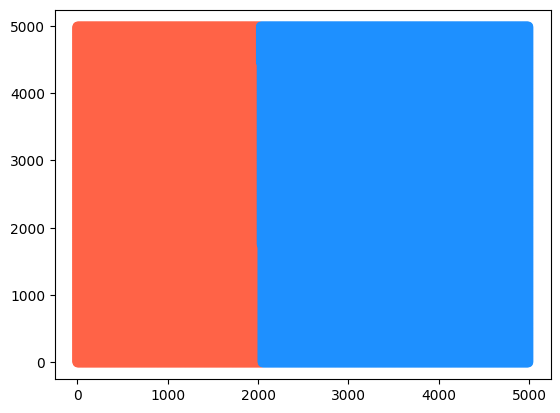

In [27]:
income = np.arange(0, 5000, 10)
balance = np.arange(0, 5000, 10)
X = []
blen = len(balance)
for i in range(len(income)):
    print(f"{i+1}/{blen}", end="\r")
    for j in range(len(balance)):
        X.append([income[i], balance[j]])
X = np.array(X)
X_constant = sm.add_constant(X)
preds = np.where(np.array(M4.predict(X_constant)) > 0.5, 1, 0)

plt.scatter(X[:,0], X[:,1], c=["dodgerblue" if preds[i] == 1 else "tomato" for i in range(len(preds))])
plt.show()
# That is NOT what I expected to see

Add a quadratic term to the model and make the same plot as before. You should now obtain a non-linear decision boundary (although if you plotted against the squared feature, you would indeed get a linear boundary!)

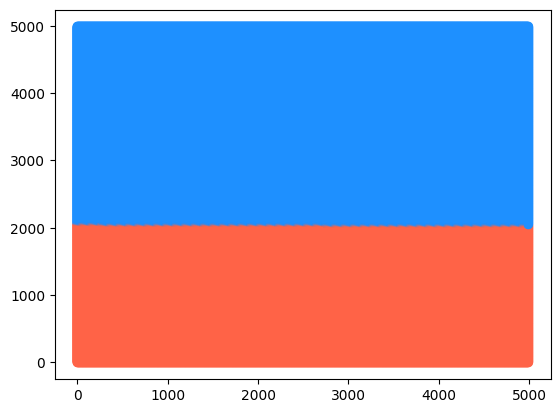

In [29]:
X_train = train_df[['income', 'balance']].copy()
X_train['balance^2'] = X_train['balance']**2
X_train_constant = sm.add_constant(X_train)
# const, income, balance, balance^2
M5 = sm.GLM(y_train, X_train_constant, family=sm.families.Binomial()).fit()

income = np.arange(0, 5000, 10)
balance = np.arange(0, 5000, 10)
X = []
blen = len(balance)
for i in range(len(income)):
    print(f"{i+1}/{blen}", end="\r")
    for j in range(len(balance)):
        X.append([income[i], balance[j], balance[j]**2])
X = np.array(X)
X_constant = sm.add_constant(X)
preds = np.where(np.array(M5.predict(X_constant)) > 0.5, 1, 0)

plt.scatter(X[:,0], X[:,1], c=["dodgerblue" if preds[i] == 1 else "tomato" for i in range(len(preds))])
plt.show()
# idk anyomre

## Interpreting a model

A) For model M1, predict the probability of defaulting for an individual with a balance of 1,000 and for an individual with balance 2,000. Try to compute the prediction from scratch yourself as well as with the `predict` method. You should obtain the same as in section 4.3.3.

B) Considering the same two individuals, how many times higher are the odds of defaulting for the individual with low balance?

C) For model M2, what are the probabilities of defaulting for students and non-students respectively? You should obtain the same as in section 4.3.3.

D) In M1, what is the interpretation of the coefficient for `balance`?

E) (optional) In model M3, compute the odds-ratio comparing the odds of defaulting for a student with high balance (2,000) and a student with a low balance (1,000). Do the same for a non-student. Note that the odds ratio differs -- this is a consequence of the *interaction* term!